In [1]:
import warnings
warnings.filterwarnings('ignore')

# Dataframe imports
import json
import time
import pandas as pd
from pandas.io.json import json_normalize
from datetime import datetime, timedelta
import itertools

# Plotting imports and defaults setup
import matplotlib as mpl
import matplotlib.pyplot as plt
SMALL_SIZE = 18
MEDIUM_SIZE = 26
BIGGER_SIZE = 30

mpl.rc('font', size=SMALL_SIZE)          # controls default text sizes
mpl.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
mpl.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
mpl.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
mpl.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
mpl.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
mpl.rc('figure', titlesize=BIGGER_SIZE)

# Scientific imports
import numpy as np
import networkx as nx

# Utilities
import itertools
import time
from datetime import datetime, timedelta
from collections import Counter, defaultdict
from itertools import chain

a4_dims = (11.7, 8.27)
windows = [86400, 604800, 2592000, 31536000]
otherwindows=[15552000,7776000]
window_names = ['1 Day', '1 week', '1 month', '1 year']

def prepare_file(fname,newname):
    startOfFile = "{\"views\":["
    endOfFile = "]}"
    with open(fname,'r') as f:
        data = f.readlines()
        f.close()
    with open(newname,'w') as tmp:
        tmp.write(startOfFile)
        tmp.write(data.pop(0).strip()+",\n")
        while len(data)>1:
            tmp.write(data.pop(0).strip()+",\n")
        tmp.write(data.pop(0).strip()+endOfFile)
        tmp.close()

def get_df(json_file):
    x = json.load(open(json_file))
    x = pd.DataFrame(x['views'])
    #x = x.drop(['_id'],axis=1)
    x['time'] = pd.to_datetime(x['time'],unit='s')
    x['index'] = pd.to_datetime(x['time'],unit='s')
    x.set_index('index', inplace=True)
    return x

# Cumulative viewtime for Raphtory debugging
Running the connected components algorithm with 1hr window, slows right down at the end due to possible memory leak.

Text(0, 0.5, 'Cumulative View Time')

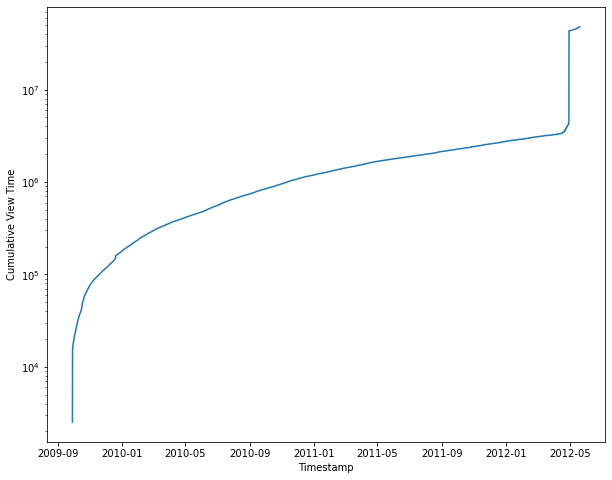

In [14]:
fig, ax = plt.subplots(figsize=(10,8))

df = get_df("CC1hr.json")
df['cumTime'] = np.cumsum(df['viewTime'])

ax.plot(df.time, df.cumTime)
ax.set_yscale('log')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Cumulative View Time')

In [ ]:
def fullPlot(toPlot,title,x,y,scale,start,end):
    windows = [31536000000,2592000000,604800000, 86400000]
    labels = ['Year Window','Month Window','Week Window','Day Window']
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    #plt.title(title,fontsize=30)
    plt.xlabel(x,fontsize=30)
    plt.ylabel(y,fontsize=30)
    ax.set_yscale(scale)

    with open('degree/degrees.json') as json_file:
        x = json.load(json_file)
        x= pd.DataFrame(x['views'])
        x['time'] = pd.to_datetime(x['time'],unit='ms')
        x['index'] = pd.to_datetime(x['time'],unit='ms')
        x.set_index('index', inplace=True)
        x =x[start:end]
        x['avgdeg']= np.where(x['vertices']<1, x['vertices'], 2*x['edges']/x['vertices'])
        x = x[x[toPlot] != 0]
        #x.plot(x='time', y=toPlot,ax=ax, label="Aggregate Graph")

    with open('degree/degreewindows.json') as json_file:
        with open('degree/degreesorted.json') as json_2:
            cc1 = json.load(json_file)
            cc2 = json.load(json_2)
            cc1= pd.DataFrame(cc1['views'])
            cc2= pd.DataFrame(cc2['views'])
            cc1['time'] = pd.to_datetime(cc1['time'],unit='ms')
            cc2['time'] = pd.to_datetime(cc2['time'],unit='ms')
            cc1.set_index('time', inplace=False)
            cc2.set_index('time', inplace=False)
            index = 0
            for i in windows:
                color=next(ax._get_lines.prop_cycler)['color']
                y = cc1[cc1['windowsize'] == i]
                mask = (y['time']>start) & (y['time'] < end) & (y['time'] > y.iloc[0]['time'] + timedelta(microseconds=1000*i))
                y=y[mask]
                y['time'] = y['time'] - timedelta(microseconds=500*i)
                z = cc2[cc2['windowsize'] == i]
                y['avgdeg']= np.where(y['vertices']<1, y['vertices'], 2*y['edges']/y['vertices'])
                z['avgdeg']= np.where(z['vertices']<1, z['vertices'], 2*z['edges']/z['vertices'])
                #y = y[y[toPlot] != 0]
                y.plot(x='time',y=toPlot,ax=ax, label=labels[index], color = color, linewidth=3)
                #z.plot(x='time', y=toPlot,ax=ax, label='_nolegend_', color = color, linestyle="--", alpha=0.8)
                index +=1

    with open('degree/degreehours.json') as json_file:
        with open('degree/degreesortedhour.json') as json_2:
            color=next(ax._get_lines.prop_cycler)['color']
            x = json.load(json_file)
            y = json.load(json_2)
            x= pd.DataFrame(x['views'])
            y= pd.DataFrame(y['views'])
            x['index'] = pd.to_datetime(x['time'],unit='ms')
            y['index'] = pd.to_datetime(y['time'],unit='ms')
            x['time'] = pd.to_datetime(x['time'],unit='ms')
            y['time'] = pd.to_datetime(y['time'],unit='ms')
            x.set_index('index', inplace=True)
            y.set_index('index', inplace=True)
            mask = (x['time'] > start) & (x['time'] < end) & (x['time'] > x.iloc[0]['time'] + timedelta(microseconds=1000*3600000))
            x =x[start:end]
            y =y[start:end]
            y['time'] = y['time'] - timedelta(microseconds=500*3600000)
            x['avgdeg']= np.where(x['vertices']<1, x['vertices'], 2*x['edges']/x['vertices'])
            y['avgdeg']= np.where(y['vertices']<1, y['vertices'], 2*y['edges']/y['vertices'])
            x['hour'] = x.apply(lambda row: int(row['time'].hour),axis=1)
            y['hour'] = y.apply(lambda row: int(row['time'].hour),axis=1)
            x = x[x[toPlot] != 0]
            y = y[y[toPlot] != 0]
            x.plot(x='time', y=toPlot,ax=ax, color=color, linewidth=3, label="Hour window")
            #y.plot(x='time', y=toPlot,ax=ax, color=color, label='_nolegend_',linestyle="--", alpha=0.8)
        
    #plt.axvline('2016-11-09',linestyle='')
    #plt.axvline('2017-08-11')
    #plt.axvline('2017-08-13')
    plt.legend(fontsize=20, loc='upper left')
    #plt.xlim(start,end)
    plt.xlabel('Date',fontsize=30)
    plt.rc('xtick',labelsize=20)
    plt.rc('ytick',labelsize=20)
    plt.savefig('graphs/'+toPlot+'def1.png')
    plt.show()

# Number of nodes, edges, average degree
First some plots of basic network statistics.

## Scaling of quantities
How do various network statistics change as the window grows? 

In [2]:
def plot_window_scale():
    toPlot=['vertices','edges','avgdeg']
    labels=['Number of Nodes', 'Number of Edges', 'Average Degree']
    start, end = datetime.fromtimestamp(1254192988),datetime.fromtimestamp(1457262355)
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    #plt.title(title,fontsize=30)
    plt.xlabel("Window size (hours)",fontsize=30)
    plt.ylabel('Size of quantity',fontsize=30)
    ax.set_xscale('log')
    ax.set_yscale('log')
    windows = np.array([86400, 604800, 2592000, 31536000])
    means = np.zeros((3,4),dtype=float)
    sds = np.zeros((3,4),dtype=float)

    with open('degreeNewWindows.json') as json_file:            
        x = json.load(json_file)
        x= pd.DataFrame(x['views'])
        x['time'] = pd.to_datetime(x['time'],unit='s')
        x['index'] = pd.to_datetime(x['time'],unit='s')
        x.set_index('index', inplace=True)
        x['avgdeg']= np.where(x['vertices']<1, x['vertices'], 2*x['edges']/x['vertices'])
        for j in range(4):
            z = x[x['windowsize']==round(windows[j])]
            mask = (z['time']>start) & (z['time'] < end) & (z['time'] > z.iloc[0]['time'] + timedelta(seconds=int(windows[j])))
            z = z[mask]
            for i in range(3):
                means[i,j]=z[toPlot[i]].mean()
                sds[i,j]=z[toPlot[i]].std()
                
    windows = windows/3600
    
    for i in range(3):
        plt.plot(windows, means[i], label = labels[i],marker='^')
        plt.fill_between(windows, means[i]-sds[i], means[i]+sds[i], alpha = 0.3)
    
    plt.rc('xtick',labelsize=20)
    plt.rc('ytick',labelsize=20)
    plt.legend(loc='upper left',fontsize=20)
    plt.savefig('windowScale.png')
    plt.show()

In [8]:
from matplotlib import gridspec
from matplotlib import ticker as mticker

def plotNewVsExisting(toPlot,start,end,y,scale):
    windows = [31536000,2592000,604800, 86400]
    labels = ['Year Window','Month Window','Week Window','Day Window', '6 Month Window', '3 Month Window']
    a4_dims = (11.7, 8.27)
    fig = plt.figure(figsize=a4_dims)
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2])
    ax0 = fig.add_subplot(gs[0])
    ax0.set_ylim((0,1))
    ax1 = fig.add_subplot(gs[1],sharex=ax0)
    formatter = mticker.ScalarFormatter(useMathText=True)
    ax1.yaxis.set_major_formatter(formatter)
    plt.xlabel("Date",fontsize=30)
    ax1.set_ylabel(y,fontsize=20, labelpad=15)
    ax1.set_yscale(scale)
    
    color=next(ax1._get_lines.prop_cycler)['color']
    
    prepare_file('noWindow.json','degreeNoWindow.json')
    aggr = get_df('degreeNoWindow.json')
    aggr =aggr[start:end]
    display(aggr)
    aggr.plot(y=toPlot,ax=ax1, label="Aggregate Graph", linestyle='--', color='black')
    
    prepare_file("newWindow.json", "degreeNewWindows.json")
    cc1 = get_df('degreeNewWindows.json')
    index = 0
    for i in windows:
        if index==0:
            index+=1
            continue
        diff_size = int(i/86400);
        color=next(ax1._get_lines.prop_cycler)['color']
        y = cc1[cc1['windowsize'] == i]
        y['new']= aggr[toPlot].diff(diff_size)
        mask = (y['time']>start) & (y['time'] < end) & (y['time'] > y.iloc[0]['time'] + timedelta(seconds=i))
        y=y[mask]
        y['prop_new'] = np.where(y[toPlot]<1,1,y['new']/y[toPlot])
        y['time'] = y['time'] - timedelta(seconds=0.5*i)
        y.set_index('time',inplace=True)
        y = y[y[toPlot] != 0]
        y.plot(y=toPlot,ax=ax1, label=labels[index], color = color, linewidth=3)
        y.plot(y="prop_new",ax=ax0, label=labels[index], color = color, linewidth=3)
        #z.plot(x='time', y=toPlot,ax=ax, label='_nolegend_', color = color, linestyle="--", alpha=0.8)
        index +=1
    
    prepare_file('3-6month.json','3-6month-degree.json')
    cc1 = get_df('3-6month-degree.json')
    
    for i in otherwindows:
        diff_size = int(i/86400);
        color=next(ax1._get_lines.prop_cycler)['color']
        y = cc1[cc1['windowsize'] == i]
        y['new']= aggr[toPlot].diff(diff_size)
        mask = (y['time']>start) & (y['time'] < end) & (y['time'] > y.iloc[0]['time'] + timedelta(seconds=i))
        y=y[mask]
        y['prop_new'] = np.where(y[toPlot]<1,1,y['new']/y[toPlot])
        display(y[y['prop_new']<1.0])
        y['time'] = y['time'] - timedelta(seconds=0.5*i)
        y.set_index('time',inplace=True)
        y = y[y[toPlot] != 0]
        #display(y)
        y.plot(y=toPlot,ax=ax1, label=labels[index], color = color, linewidth=3)
        y.plot(y="prop_new",ax=ax0, label=labels[index], color = color, linewidth=3)
        index +=1

    if toPlot=='vertices':
        height=100000
    else:
        height=2500000
        
    ax0.get_legend().remove()
    
    handles,labels = ax1.get_legend_handles_labels()
    l1, l2, l3 = handles[:1], handles[1:4], handles[4:]
    handles = l1 + l3 + l2
    l1, l2, l3 = labels[:1], labels[1:4], labels[4:]
    labels = l1 + l3 + l2
    
    ax0.grid(False)
    ax1.grid(False)
    ax0.set_title("Proportion of "+toPlot+" that are new", fontsize=20)
    ax1.legend(handles, labels, fontsize=15, loc='lower right')
    plt.xlabel('Date',fontsize=30)
    plt.rc('xtick',labelsize=20)
    plt.rc('ytick',labelsize=20)
    fig.tight_layout()
    plt.savefig("sx"+toPlot+'newVsExisting.png')
    plt.show()

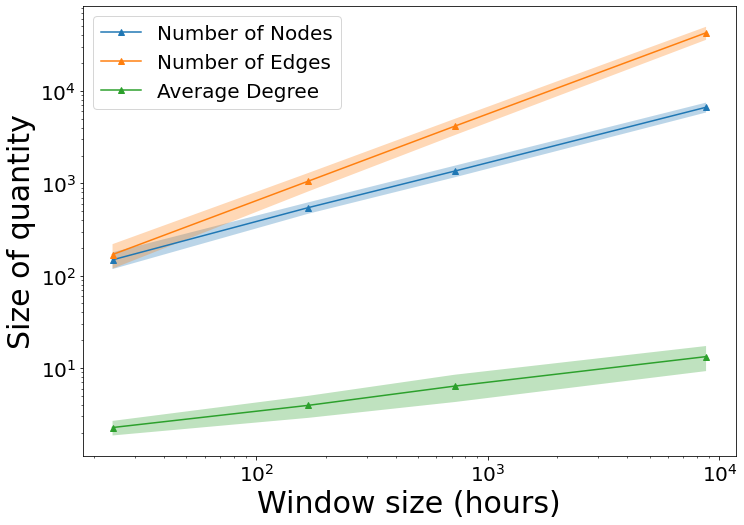

In [91]:
plot_window_scale()

## Number of nodes (new vs existing)

,degree,viewTime,edges,time,vertices
index,,,,,
2009-09-30 02:56:28,1.500000,6,15,2009-09-30 02:56:28,10
2009-10-01 02:56:28,1.727273,6,19,2009-10-01 02:56:28,11
2009-10-02 02:56:28,1.750000,6,28,2009-10-02 02:56:28,16
2009-10-03 02:56:28,1.952381,7,41,2009-10-03 02:56:28,21
2009-10-04 02:56:28,2.043478,7,47,2009-10-04 02:56:28,23
...,...,...,...,...,...
2016-03-02 02:56:28,9.214378,342,227632,2016-03-02 02:56:28,24704
2016-03-03 02:56:28,9.213555,250,227713,2016-03-03 02:56:28,24715
2016-03-04 02:56:28,9.211475,267,227809,2016-03-04 02:56:28,24731


,degree,windowsize,viewTime,edges,time,vertices,new,prop_new
index,,,,,,,,
2010-03-29 02:56:28,9.301853,15552000,39,21078,2010-03-29 02:56:28,2266,2257.0,0.996028
2010-03-30 02:56:28,9.310663,15552000,54,21219,2010-03-30 02:56:28,2279,2270.0,0.996051
2010-03-31 02:56:28,9.327511,15552000,37,21360,2010-03-31 02:56:28,2290,2276.0,0.993886
2010-04-01 02:56:28,9.357671,15552000,45,21532,2010-04-01 02:56:28,2301,2282.0,0.991743
2010-04-02 02:56:28,9.392114,15552000,43,21677,2010-04-02 02:56:28,2308,2288.0,0.991334
...,...,...,...,...,...,...,...,...
2016-03-02 02:56:28,3.446532,15552000,81,16695,2016-03-02 02:56:28,4844,1767.0,0.364781
2016-03-03 02:56:28,3.442954,15552000,62,16688,2016-03-03 02:56:28,4847,1767.0,0.364555
2016-03-04 02:56:28,3.446892,15552000,75,16745,2016-03-04 02:56:28,4858,1779.0,0.366200


,degree,windowsize,viewTime,edges,time,vertices,new,prop_new
index,,,,,,,,
2009-12-29 02:56:28,7.726408,7776000,31,9743,2009-12-29 02:56:28,1261,1252.0,0.992863
2009-12-30 02:56:28,7.732914,7776000,51,9844,2009-12-30 02:56:28,1273,1264.0,0.992930
2009-12-31 02:56:28,7.785324,7776000,20,9973,2009-12-31 02:56:28,1281,1267.0,0.989071
2010-01-01 02:56:28,7.843823,7776000,26,10095,2010-01-01 02:56:28,1287,1268.0,0.985237
2010-01-02 02:56:28,7.869296,7776000,24,10175,2010-01-02 02:56:28,1293,1273.0,0.984532
...,...,...,...,...,...,...,...,...
2016-03-02 02:56:28,2.668074,7776000,46,8215,2016-03-02 02:56:28,3079,901.0,0.292627
2016-03-03 02:56:28,2.658347,7776000,52,8201,2016-03-03 02:56:28,3085,900.0,0.291734
2016-03-04 02:56:28,2.664286,7776000,45,8206,2016-03-04 02:56:28,3080,902.0,0.292857


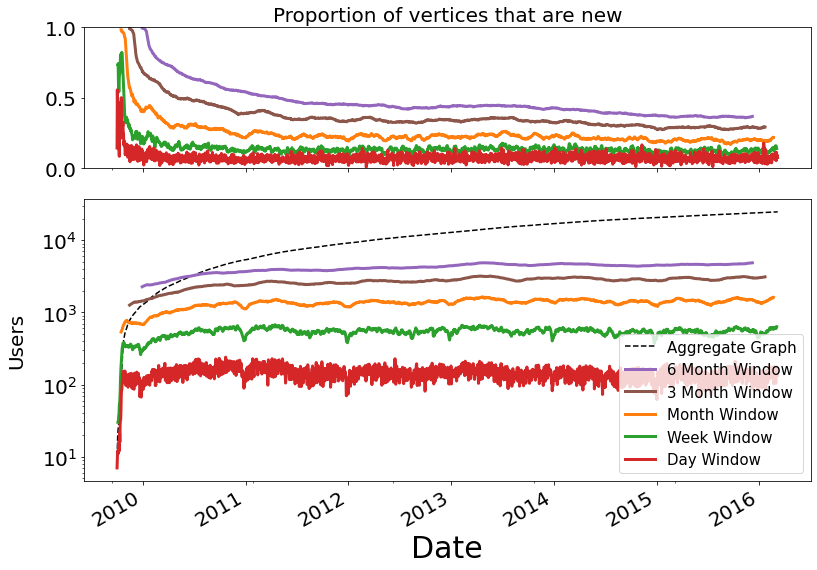

In [9]:
plotNewVsExisting('vertices',datetime.fromtimestamp(1254192988),datetime.fromtimestamp(1457262355),'Users','log')

## Number of edges (new vs existing)

,degree,viewTime,edges,time,vertices
index,,,,,
2009-09-30 02:56:28,1.500000,6,15,2009-09-30 02:56:28,10
2009-10-01 02:56:28,1.727273,6,19,2009-10-01 02:56:28,11
2009-10-02 02:56:28,1.750000,6,28,2009-10-02 02:56:28,16
2009-10-03 02:56:28,1.952381,7,41,2009-10-03 02:56:28,21
2009-10-04 02:56:28,2.043478,7,47,2009-10-04 02:56:28,23
...,...,...,...,...,...
2016-03-02 02:56:28,9.214378,342,227632,2016-03-02 02:56:28,24704
2016-03-03 02:56:28,9.213555,250,227713,2016-03-03 02:56:28,24715
2016-03-04 02:56:28,9.211475,267,227809,2016-03-04 02:56:28,24731


,degree,windowsize,viewTime,edges,time,vertices,new,prop_new
index,,,,,,,,
2010-03-29 02:56:28,9.301853,15552000,39,21078,2010-03-29 02:56:28,2266,21069.0,0.999573
2010-03-30 02:56:28,9.310663,15552000,54,21219,2010-03-30 02:56:28,2279,21210.0,0.999576
2010-03-31 02:56:28,9.327511,15552000,37,21360,2010-03-31 02:56:28,2290,21346.0,0.999345
2010-04-01 02:56:28,9.357671,15552000,45,21532,2010-04-01 02:56:28,2301,21513.0,0.999118
2010-04-02 02:56:28,9.392114,15552000,43,21677,2010-04-02 02:56:28,2308,21656.0,0.999031
...,...,...,...,...,...,...,...,...
2016-03-02 02:56:28,3.446532,15552000,81,16695,2016-03-02 02:56:28,4844,13694.0,0.820246
2016-03-03 02:56:28,3.442954,15552000,62,16688,2016-03-03 02:56:28,4847,13685.0,0.820050
2016-03-04 02:56:28,3.446892,15552000,75,16745,2016-03-04 02:56:28,4858,13738.0,0.820424


,degree,windowsize,viewTime,edges,time,vertices,new,prop_new
index,,,,,,,,
2009-12-29 02:56:28,7.726408,7776000,31,9743,2009-12-29 02:56:28,1261,9734.0,0.999076
2009-12-30 02:56:28,7.732914,7776000,51,9844,2009-12-30 02:56:28,1273,9835.0,0.999086
2009-12-31 02:56:28,7.785324,7776000,20,9973,2009-12-31 02:56:28,1281,9959.0,0.998596
2010-01-01 02:56:28,7.843823,7776000,26,10095,2010-01-01 02:56:28,1287,10076.0,0.998118
2010-01-02 02:56:28,7.869296,7776000,24,10175,2010-01-02 02:56:28,1293,10154.0,0.997936
...,...,...,...,...,...,...,...,...
2016-03-02 02:56:28,2.668074,7776000,46,8215,2016-03-02 02:56:28,3079,6626.0,0.806573
2016-03-03 02:56:28,2.658347,7776000,52,8201,2016-03-03 02:56:28,3085,6623.0,0.807584
2016-03-04 02:56:28,2.664286,7776000,45,8206,2016-03-04 02:56:28,3080,6628.0,0.807702


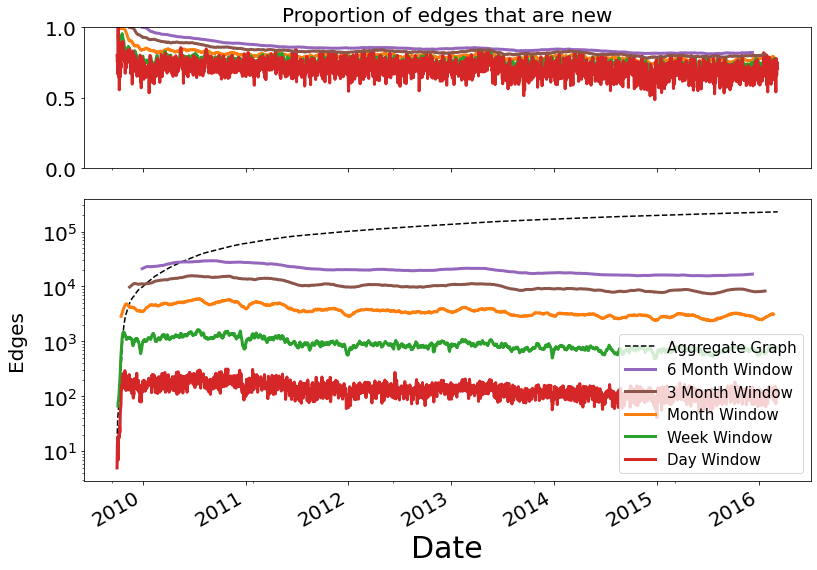

In [10]:
plotNewVsExisting('edges',datetime.fromtimestamp(1254192988),datetime.fromtimestamp(1457262355),'Edges','log')

In [10]:
def activeUserPlot(toPlot):
    windows = [31536000,2592000,604800,86400]
    labels = ['Year Window','Month Window','Week Window','Day Window']
    a4_dims = (11.7, 4.11)
    fig, ax = plt.subplots(figsize=a4_dims)
    start, end = datetime.fromtimestamp(1254192988),datetime.fromtimestamp(1457262355)
    
    with open('degreeNoWindow.json') as json_file:
        x = json.load(json_file)
        x= pd.DataFrame(x['views'])
        x['time'] = pd.to_datetime(x['time'],unit='s')
        x['index'] = pd.to_datetime(x['time'],unit='s')
        x.set_index('index', inplace=True)
        total =x[start:end][toPlot]
        json_file.close()
        
    with open('degreeNewWindows.json') as json_file:
        cc1 = json.load(json_file)
        cc1= pd.DataFrame(cc1['views'])
        cc1['time'] = pd.to_datetime(cc1['time'],unit='s')
        cc1['index'] = pd.to_datetime(cc1['time'],unit='s')
        cc1.set_index('index', inplace=True)
        cc1 = cc1[start:end]
        index=0
        print(cc1)
        for i in windows:
#             if index==3:
#                 total.drop(total.tail(1).index,inplace=True)
            color=next(ax._get_lines.prop_cycler)['color']
            y = cc1[cc1['windowsize'] == i]
            print(len(y))
            y['prop'] = np.where(total < 1, total, y[toPlot]/total)
            if index==1:
                monthvals=y['vertices']
            if index==3:
                print(np.mean(y['vertices']/monthvals))
                
            mask = (y['time']>=start) & (y['time'] <= end) & (y['time'] >= y.iloc[0]['time'] + timedelta(seconds=i))
            y=y[mask]
            y.set_index('time',inplace=True)
            y.set_index('time',inplace=True)
            y.plot(y='prop',ax=ax, label=labels[index], color = color, linewidth=3)
            index+=1
      
    plt.ylabel('Proportion of userbase active',fontsize=20)
    plt.xlabel('Date',fontsize=30)
    plt.rc('xtick',labelsize=20)
    plt.rc('ytick',labelsize=20)
    plt.savefig(toPlot+'ProportionActive.png')
    plt.show()

                       degree  windowsize  viewTime  edges  \
index                                                        
2009-09-30 02:56:28  1.500000    31536000         6     15   
2009-09-30 02:56:28  1.500000     2592000         6     15   
2009-09-30 02:56:28  1.500000      604800         6     15   
2009-09-30 02:56:28  1.400000       86400         6     14   
2009-10-01 02:56:28  1.727273    31536000         7     19   
...                       ...         ...       ...    ...   
2016-03-05 02:56:28  0.717949       86400        21    112   
2016-03-06 02:56:28  4.206787    31536000       104  31858   
2016-03-06 02:56:28  1.942486     2592000        59   3141   
2016-03-06 02:56:28  1.194006      604800        33    757   
2016-03-06 02:56:28  0.738806       86400        22     99   

                                   time  vertices  
index                                              
2009-09-30 02:56:28 2009-09-30 02:56:28        10  
2009-09-30 02:56:28 2009-09-30 02:56:

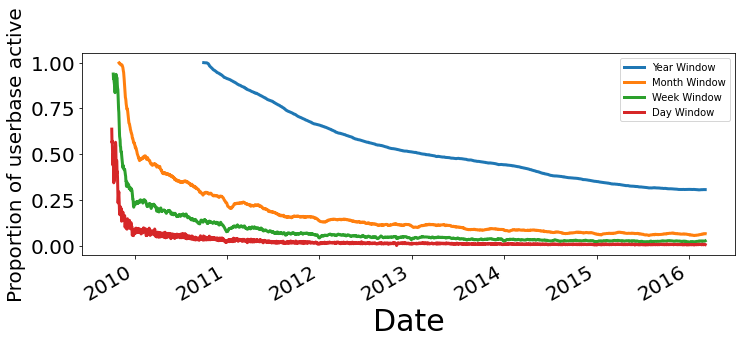

In [11]:
activeUserPlot('vertices')

0.1575872350713192
0.14977032798775083
0.589284553414711


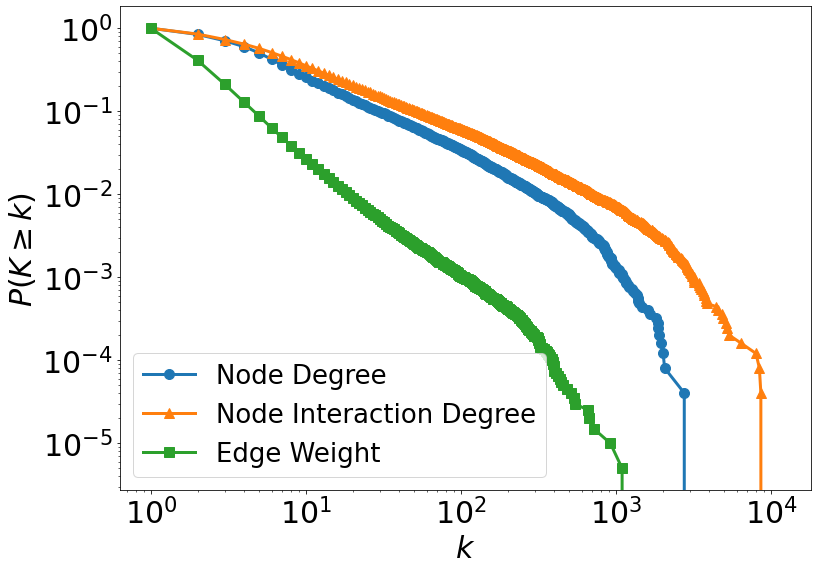

In [19]:
fig, ax = plt.subplots(figsize=a4_dims, sharex=True)

file = 'distributions.json'
dist = get_df(file)

toPlot = ['degDist', 'weightDist', 'edgeDist']
labels = ['Node Degree', 'Node Interaction Degree', 'Edge Weight']
markers = ['o','^','s']
index = ['degree', 'weight', 'eweight']

for j in range(3):
    degdist = map(lambda x: (x[index[j]], x['freq']), dist.iloc[0][toPlot[j]])
    dd = sorted(list(degdist), key = lambda x: x[0])
    print(dd[0][1]/sum([dd[j][1] for j in range(len(dd))]))

    cumsum = np.array([sum(list(map(lambda x: x[1], dd[:i]))) for i in range(len(dd))])
    ccdf = 1 - cumsum/cumsum[-1]

    ax.plot(list(map(lambda x: x[0], dd)), ccdf, label=labels[j], marker = markers[j],markersize=10, linewidth=3)

ax.legend(loc="lower left",fontsize=26)
ax.set_xscale('log')
ax.set_xlabel('$k$',fontsize = 30)
ax.set_yscale('log')
ax.set_ylabel('$P(K\geq k)$',fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
plt.savefig('SXDistributions.png')
plt.show()

In [5]:
def get_users(cell):
    if len(cell)==0:
        return []
    return list(pd.DataFrame(cell)['id'])

def how_many_windows(x,y,title,scale):
    
    start, end = datetime.fromtimestamp(1254192988),datetime.fromtimestamp(1457262355)
    windows = [31536000,2592000,604800,86400]
    labels = ['Year Window','Month Window','Week Window','Day Window']
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    
    plt.xlabel(x, size=30)
    plt.ylabel(y, size=30)
    ax.set_yscale(scale)
    
    degs = get_df('degreeRankingFix.json')
    
    #color=next(ax._get_lines.prop_cycler)['color']
    
    index=0
    for i in windows:
        color=next(ax._get_lines.prop_cycler)['color']
        y = degs[degs['windowsize'] == i]
        y['topusers']=y.apply(lambda row: get_users(row['bestusers']),axis=1)
        #y['topusers']=topusers
        mask = (y['time']>=start) & (y['time'] <= end) & (y['time'] >= y.iloc[0]['time'] + timedelta(seconds=i))
        y=y[mask]
        total_windows = len(y)
        users_count = Counter(chain.from_iterable(set(row) for row in y['topusers']))
        meta = Counter(users_count.values())
        x1,y1 = zip(*sorted(meta.items()))
        x1 = np.array(x1)/total_windows
        y1 = np.cumsum(np.array(y1))
        ccdf = len(users_count.items())-y1
        ax.plot(x1, ccdf, label=labels[index], linewidth=3,color=color)
        index+=1
        
    plt.legend(loc='upper right', fontsize=20)
    plt.tight_layout()
    plt.savefig("top20CCDF.png")
    plt.show()

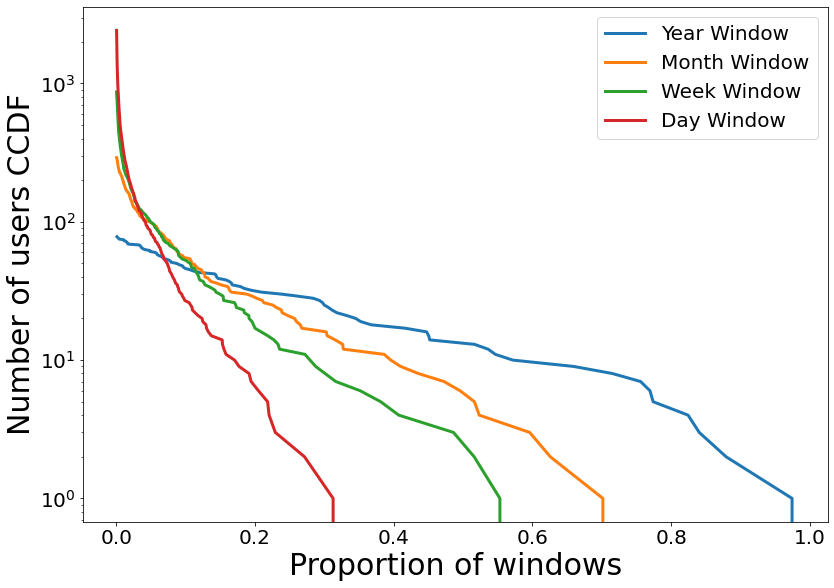

In [65]:
how_many_windows('Proportion of windows','Number of users CCDF','lol','log')

In [11]:
def get_degree(rankings, user):
    for row in rankings:
        if row['id']==user:
            return row['indegree']
    return None

def get_deg_trajectory(user, pr):
    traj = np.asarray(list(pr['bestusers'].apply(lambda row: get_degree(row,user))))/pr['vertices']
    return traj

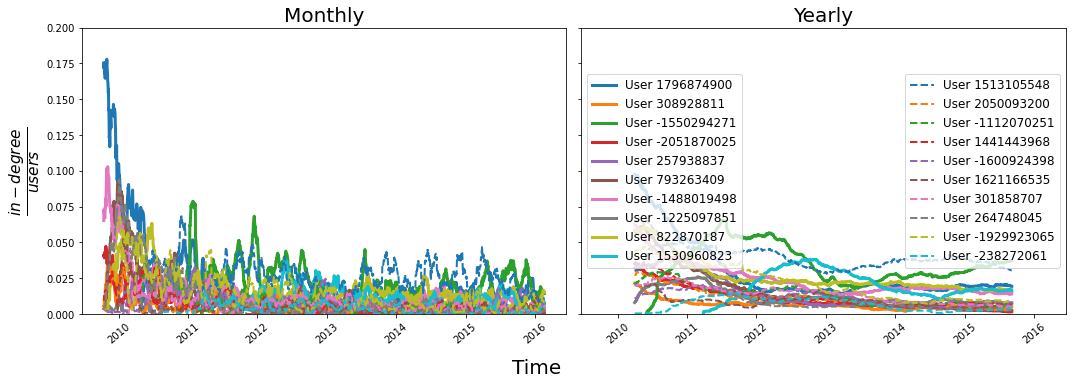

In [15]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5), sharex=True, sharey=True)

file = "trackedDegree.json"
vfile = "degreeNewWindows.json"

start, end = datetime.fromtimestamp(1254192988),datetime.fromtimestamp(1457262355)

degree, vertices = get_df(file), get_df(vfile)
degree, vertices = degree[start:end], vertices[start:end]

windows = [2592000, 31536000]
window_names = ['Monthly', 'Yearly']

linecols = defaultdict(lambda : next(ax._get_lines.prop_cycler)['color'])

for i, ax in enumerate(axes.flatten()):
    #ax.set_xlabel('Time',fontsize=20)
    window = windows[i]
    name = window_names[i]
    y, z = degree, vertices
    mask = (y['time']>=start) & (y['time'] <= end) & (y['time'] >= y.iloc[0]['time'] + timedelta(seconds=window))
    y=y[mask]
    mask = (z['time']>=start) & (z['time'] <= end) & (z['time'] >= z.iloc[0]['time'] + timedelta(seconds=window))
    z=z[mask]
    y['time'] = y['time'] - timedelta(seconds=0.5*window)
    z['time'] = z['time'] - timedelta(seconds=0.5*window)
    #mo = y[y['windowsize']==window]
    mo = y[y['windowsize']==window]
    z = z[z['windowsize']==window]
    mo['vertices']=z['vertices']
    #indeg = mo.apply(lambda t: (pd.DataFrame(t.TopUsers).set_index('id').indegree/ t.vertices).to_dict(), axis=1)
    #ideg = indeg.apply(pd.Series)
    #top = ideg.max().sort_values(ascending=False).index[:20]
    top = [1796874900,308928811,-1550294271,-2051870025,257938837,793263409,-1488019498,-1225097851,
           822870187,1530960823,1513105548,2050093200,-1112070251,1441443968,-1600924398,1621166535,
           301858707,264748045,-1929923065,-238272061]
    times = np.asarray(mo['time'])
    #all_users = list(itertools.chain.from_iterable(pr['TopUsers'].tolist()))
    #unique_users = list(map(lambda y:y[0],Counter(list(map(lambda row: row['id'], all_users))).most_common(30)))
    #unique_users = (31,4987,1981,709,1175,18992,491,5196,1759,4555)
    left_user_labels, right_user_labels = [], []
    left_user_plots, right_user_plots = [], []
    for k, user in enumerate(list(top)):
        if k<10:
            left_user_plots.append(ax.plot(times,get_deg_trajectory(user,mo),color=linecols[user], linewidth=3)[0])
            left_user_labels.append("User "+str(user))
        else:
            right_user_plots.append(ax.plot(times,get_deg_trajectory(user,mo),color=linecols[user], linewidth=2, linestyle="--")[0])
            right_user_labels.append("User "+str(user))
    index=1
    ax.xaxis.set_tick_params(rotation=40)
    #ax.legend(framealpha=0.6)
    ax.set_ylim(0,0.2)
    ax.set_title(name,fontsize=20)
    
l1 = plt.legend(left_user_plots, left_user_labels, loc='center left', fontsize=12)
l2 = plt.legend(right_user_plots, right_user_labels, loc='center right',fontsize=12)
plt.gca().add_artist(l1)

fig.text(0.5, -0.05, 'Time', fontsize=20, ha='center')

axes[0].set_ylabel(r'$\frac{in-degree}{users}$', fontsize=22)
plt.tight_layout()
plt.savefig('DegreeTrajectoriesSelective.png')
plt.show()